<a href="https://colab.research.google.com/github/AlexLeoShin/SeminarGit/blob/main/m7_t4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import sklearn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
h = pd.read_csv("/content/drive/MyDrive/Модуль 7 Машинное обучение/heart3.csv")#, header=None)
feature_names=h.columns.tolist()
print(h.head(3))
print(feature_names)
print(h.shape)

   Бронхиальная астма  Возраст алког  Работа  Переломы  Время пробуждения  \
0                   0           18.0       1         0                  6   
1                   0           90.0       0         1                  4   
2                   0           17.0       0         0                  7   

   ЛПВП  Выход на пенсию  Холестерин  Артериальная гипертония  Триглицериды  \
0  0.97                0         4.0                        0          0.52   
1  0.74                0         8.6                        0          2.73   
2  1.57                0         5.2                        0          1.02   

   ...  Время засыпания  Хроническое заболевание легких  Сигарет в день  \
0  ...               10                               0            20.0   
1  ...               12                               0             0.0   
2  ...               11                               0             0.0   

   Образование  Индекс массы тела, кг/м^2  Прекращение работы по болезни 

In [4]:
X = h.drop(['ССЗ'], axis=1)
y = h['ССЗ'].values
h_columns = X.columns

In [5]:
# 1  валидация Hold-out
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
print('Обучающая выборка- ',X_train.shape)
print('Тестовая выборка- ',X_test.shape)

Обучающая выборка-  (759, 34)
Тестовая выборка-  (190, 34)


In [7]:
# 2  Трёхкомпонентное разбиение, когда нужна настройка гиперпараметров. Разделение: train (80%) — обучение модели, validation (10%) — подбор гиперпараметров, test (10%) — финальная оценка.
# Сначала train и temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
# Затем temp → validation и test
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [8]:
print('Обучающая выборка- ',X_train.shape)
print('Валидационная выборка- ',X_valid.shape)
print('Тестовая выборка- ',X_test.shape)

Обучающая выборка-  (759, 34)
Валидационная выборка-  (95, 34)
Тестовая выборка-  (95, 34)


In [23]:
# 3  Кросс-валидация (k-fold)
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_validate
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=7, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_metrics = cross_validate(estimator=tree,X=X, y=y, cv=kf,scoring='accuracy',return_train_score=True)

print(f"Средние значения точности по фолдам на обучении: {cv_metrics['train_score'].mean():.2f}")
print(f"Средние значения точности по фолдам на валидации: {cv_metrics['test_score'].mean():.2f}")

Средние значения точности по фолдам на обучении: 1.00
Средние значения точности по фолдам на валидации: 0.99


Thresholds: [0.   0.01 0.02 0.03 0.04]
Precision scores: [0.55862978 0.61988304 0.6645768  0.70549085 0.7373913 ]
Recall scores: [1. 1. 1. 1. 1.]
Best threshold = 0.38, F1-Score = 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        47
           1       1.00      1.00      1.00        48

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

PR AUC: 1.00


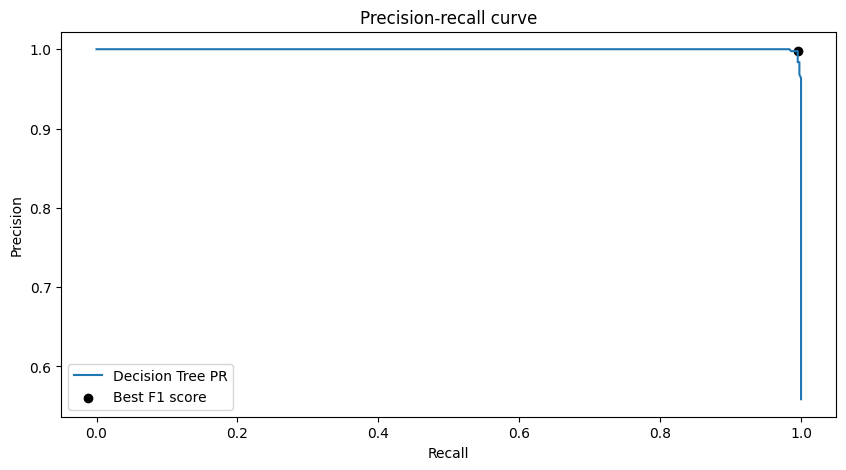

In [24]:
skf = model_selection.StratifiedKFold(n_splits=5)
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')
y_cv_proba_pred = y_cv_proba_pred[:, 1]
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

#Вычисляем F1-меру при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5))
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend();
#Задаём оптимальный порог вероятностей
threshold_opt = 0.33 # можно заменить на threshold[idx]

y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba > threshold_opt).astype('int')
#Считаем метрики
print(metrics.classification_report(y_valid, y_valid_pred))
print('PR AUC: {:.2f}'.format(metrics.auc(recall, precision)))

In [ ]:
cm_flat = cm.flatten()
print(f"контрольный результат confusion matrix: [{cm_flat[0]} {cm_flat[1]} {cm_flat[2]} {cm_flat[3]}]")

In [17]:
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
cv_metrics = cross_validate(tree, X, y, cv=kf, scoring=scoring, return_train_score=True)

print(f"Accuracy:  {cv_metrics['test_accuracy'].mean():.2f}")
print(f"Precision: {cv_metrics['test_precision_macro'].mean():.2f}")
print(f"Recall:    {cv_metrics['test_recall_macro'].mean():.2f}")
print(f"F1 Score:  {cv_metrics['test_f1_macro'].mean():.2f}")

Accuracy:  0.99
Precision: 0.99
Recall:    0.99
F1 Score:  0.99


In [18]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=13, class_weight = 'balanced_subsample')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', random_state=13)

Производительность модели -  0.9789473684210527
Площадь под ROC-кривой 0.9997781721384206
Матрица ошибок 
 [[46  0]
 [ 2 47]]


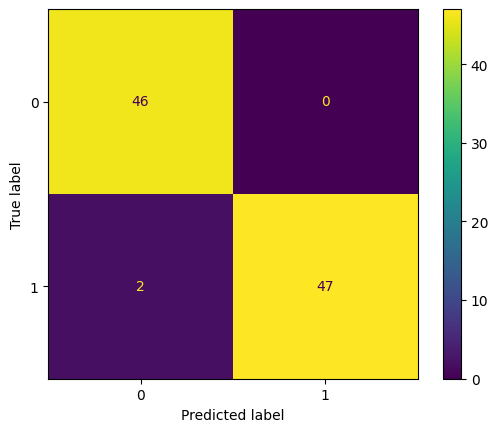

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

predicted = model.predict(X_test)
print('Производительность модели - ',model.score(X_test, y_test))
probabilities = model.predict_proba(X_test)
print('Площадь под ROC-кривой',roc_auc_score(y_test, probabilities[:, 1]))
cm=confusion_matrix(y_test, predicted)
print('Матрица ошибок \n',cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

AUC-  0.9997781721384206


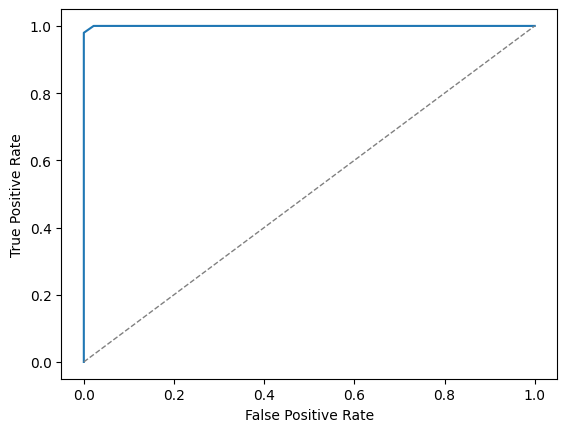

In [20]:
from sklearn import metrics
fpr, tpr, _ = roc_curve(y_test, probabilities[:, 1])
auc=metrics.auc(fpr, tpr)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC- ',auc)

In [21]:
#интерактивная визуализация с помощью plotly
import plotly.graph_objs as go

trace = go.Scatter(x=fpr, y=tpr, mode='lines', name='AUC = %0.2f' % auc,
                   line=dict(color='darkorange', width=2))
reference_line = go.Scatter(x=[0,1], y=[0,1], mode='lines', name='Reference Line',
                            line=dict(color='navy', width=2, dash='dash'))
fig = go.Figure(data=[trace, reference_line])
fig.update_layout(title='Interactive ROC Curve',
                  xaxis_title='False Positive Rate',
                  yaxis_title='True Positive Rate')
fig.show()

In [22]:
#Оценка регрессионнй модели
from sklearn.ensemble import RandomForestRegressor
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
m = RandomForestRegressor(n_estimators=100, random_state=42)
m.fit(X_train, y_train)
y_pred = m.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
med_ae = median_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE):        {mae:.4f}")
print(f"Mean Squared Error (MSE):         {mse:.4f}")
print(f"Root Mean Squared Error (RMSE):   {rmse:.4f}")
print(f"R² Score:                         {r2:.4f}")
print(f"Median Absolute Error:            {med_ae:.4f}")


Mean Absolute Error (MAE):        0.0167
Mean Squared Error (MSE):         0.0121
Root Mean Squared Error (RMSE):   0.1100
R² Score:                         0.9515
Median Absolute Error:            0.0000
